### Prawler Oxygen Analyis 
Correction to oxy profiles

In [4]:
import warnings
#remove the numpy/pandas/cython warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed,")

from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

df = pd.read_csv(e.get_search_url(response='csv', search_for='PRAWLER'))

print('We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
))

prawlers = df['Dataset ID'].values
print(prawlers)

We have 11 tabledap, 0 griddap, and 0 wms endpoints.
['erddap_4fd3_fb30_b89f' 'erddap_17bsitae_prawler'
 'erddap_17ckitaem2a_prawler' 'erddap_18bsitaepr2a_prawler'
 'erddap_18mtitaepr1a_prawler' 'erddap_19bsitaepr2a_prawler'
 'erddap_19CKitaepr2a_prawler' 'erddap_17ckitaem2a_met'
 'erddap_18bsitaepr2a_met' 'erddap_18mtitaepr1a_met'
 'erddap_19bsitaepr2a_met']


### retrieving and plotting data

In [5]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='erddap_18bsitaepr2a_prawler'

d.variables =  [
 'profile_id',
 'Temperature',
 'Salinity',
 'Chlorophyll',
 'Turbidity',
 'latitude',
 'longitude',
 'depth',
 "time",
 'Oxy_Conc',
 'Oxy_Sat'
]

d.constraints = {
    'time>=': '2018-01-01T00:00:00Z',
    'time<=': '2019-10-10T00:00:00Z',
}

In [6]:
df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.sort_index(inplace=True)
df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

df.tail()

,profile_id,Temperature,Salinity,Chlorophyll,Turbidity,latitude,longitude,depth,Oxy_Conc,Oxy_Sat
time (UTC),,,,,,,,,,
2018-10-01 20:07:09+00:00,18bsitaepr2a_p5193,5.227,32.155,0.799,98.736,56.863998,195.947006,40.8,265.70862,87.25975
2018-10-01 20:07:17+00:00,18bsitaepr2a_p5193,5.199,32.140,0.230,1.573,56.863998,195.947006,42.6,255.78642,83.93611
2018-10-01 20:07:25+00:00,18bsitaepr2a_p5193,5.172,32.082,0.230,13.286,56.863998,195.947006,43.7,248.74664,81.53549
2018-10-01 20:07:33+00:00,18bsitaepr2a_p5193,5.164,32.055,0.194,3.073,56.863998,195.947006,45.0,241.93170,79.26952
2018-10-01 20:07:41+00:00,18bsitaepr2a_p5193,5.173,32.034,0.218,1.186,56.863998,195.947006,45.4,236.68439,77.55346


In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [8]:
dfsg = df.groupby('profile_id')

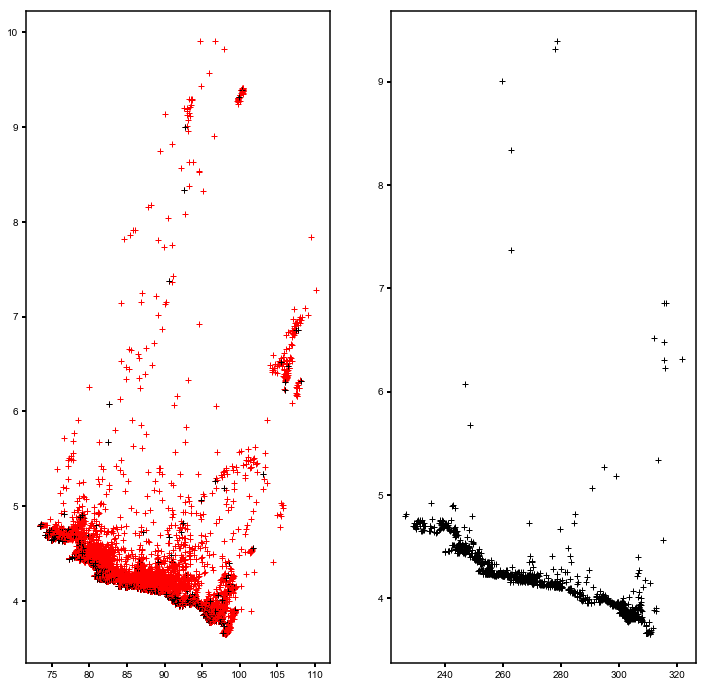

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12, 12))
mld = pd.DataFrame(columns=['MixedLayerDepth','DateTime'])
temp_mld = 0
for i,cast in enumerate(dfsg.groups):
    if dfsg.get_group(cast)['depth'].std() > 1:
        temp_mld = dfsg.get_group(cast)['depth'][(dfsg.get_group(cast)['Temperature'].diff() / dfsg.get_group(cast)['depth'].diff()).idxmin()]
        mld = mld.append({'MixedLayerDepth':temp_mld,
                   'DateTime': (dfsg.get_group(cast)['Temperature'].diff() / dfsg.get_group(cast)['depth'].diff()).idxmin()},
                   ignore_index=True)
    if (dfsg.get_group(cast)['depth'].std() < 1) and (dfsg.get_group(cast)['depth'].median() > temp_mld) and (temp_mld > 15):
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'],dfsg.get_group(cast)['Temperature'],'r+')
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'].last('s'),dfsg.get_group(cast)['Temperature'].last('s'),'k+')
        cs = ax[1].plot(dfsg.get_group(cast)['Oxy_Conc'].last('s'),dfsg.get_group(cast)['Temperature'].last('s'),'k+')
        


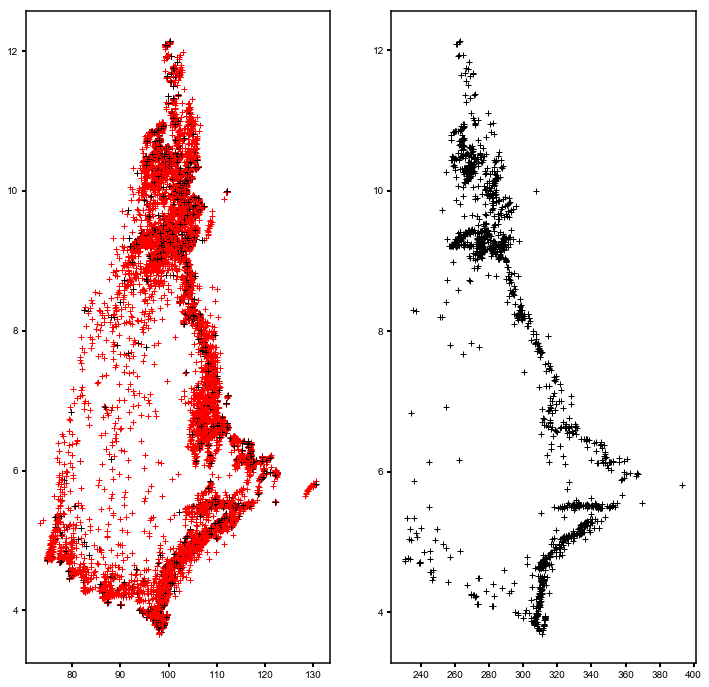

In [10]:
fig, ax = plt.subplots(1,2,figsize=(12, 12))
mld = pd.DataFrame(columns=['MixedLayerDepth','DateTime'])
temp_mld = 0
for i,cast in enumerate(dfsg.groups):
    if dfsg.get_group(cast)['depth'].std() > 1:
        temp_mld = dfsg.get_group(cast)['depth'][(dfsg.get_group(cast)['Temperature'].diff() / dfsg.get_group(cast)['depth'].diff()).idxmin()]
        mld = mld.append({'MixedLayerDepth':temp_mld,
                   'DateTime': (dfsg.get_group(cast)['Temperature'].diff() / dfsg.get_group(cast)['depth'].diff()).idxmin()},
                   ignore_index=True)
    if (dfsg.get_group(cast)['depth'].std() < 1) and (dfsg.get_group(cast)['depth'].median() < temp_mld) and (temp_mld > 15):
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'],dfsg.get_group(cast)['Temperature'],'r+')
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'].last('s'),dfsg.get_group(cast)['Temperature'].last('s'),'k+')
        cs = ax[1].plot(dfsg.get_group(cast)['Oxy_Conc'].last('s'),dfsg.get_group(cast)['Temperature'].last('s'),'k+')
        


/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


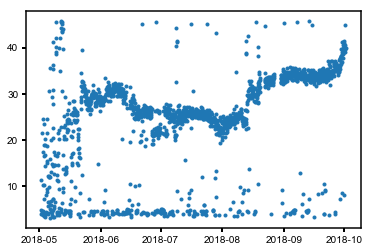

In [11]:
plt.plot(mld.DateTime,mld.MixedLayerDepth,'.')

In [12]:
dfsg.get_group(cast).columns

Index(['profile_id', 'Temperature', 'Salinity', 'Chlorophyll', 'Turbidity',
       'latitude', 'longitude', 'depth', 'Oxy_Conc', 'Oxy_Sat'],
      dtype='object')

In [13]:
print('ProfileID, Time, Oxy_Sat, Temperature, Depth')
for i,cast in enumerate(dfsg.groups):
    if dfsg.get_group(cast)['depth'].std() < 1:
        print(f"{dfsg.get_group(cast)['profile_id'].last('s').values[0]},{dfsg.get_group(cast).index[-1]},{dfsg.get_group(cast)['Oxy_Sat'].last('s').values[0]},\
{dfsg.get_group(cast)['Temperature'].last('s').values[0]},{dfsg.get_group(cast)['depth'].last('s').values[0]}")

ProfileID, Time, Oxy_Sat, Temperature, Depth
18bsitaepr2a_p0003,2018-05-01 20:56:09+00:00,98.703804,3.707,5.6
18bsitaepr2a_p0004,2018-05-01 21:01:24+00:00,98.74368,3.7310000000000003,10.4
18bsitaepr2a_p0005,2018-05-01 21:11:02+00:00,98.598206,3.698,15.8
18bsitaepr2a_p0006,2018-05-01 21:15:59+00:00,98.46944,3.674,21.4
18bsitaepr2a_p0007,2018-05-01 21:20:50+00:00,98.33516999999999,3.662,26.5
18bsitaepr2a_p0008,2018-05-01 21:30:10+00:00,98.25726,3.658,31.9
18bsitaepr2a_p0009,2018-05-01 21:34:55+00:00,98.20933000000001,3.656,35.7
18bsitaepr2a_p0010,2018-05-01 21:39:39+00:00,98.17359,3.6510000000000002,40.3
18bsitaepr2a_p0012,2018-05-01 22:09:16+00:00,98.928444,3.7689999999999997,5.5
18bsitaepr2a_p0013,2018-05-01 22:14:49+00:00,98.871826,3.722,11.0
18bsitaepr2a_p0014,2018-05-01 22:24:09+00:00,98.718094,3.705,15.7
18bsitaepr2a_p0015,2018-05-01 22:29:18+00:00,98.56235500000001,3.68,21.5
18bsitaepr2a_p0016,2018-05-01 22:34:09+00:00,98.415825,3.674,26.5
18bsitaepr2a_p0017,2018-05-01 22:43:42+00

### Bottom O2 Correction Algorithm

In [14]:
### Algorithm to tease out useful orofiles for oxygen

# Vars needed, Temp, OxySat
# Grid Profile data to 1m
# Grid Cal data to 1m
## time interpolate to make matching gridded data set for cal data with profile data

from netCDF4 import date2num, num2date
import datetime
from scipy import interpolate

### vertically grid data to evenly space gridspoints
# deployment depth has a maximum value - set at 50 generically
interval = 1.0 #m
press_grid = np.arange(0,50,interval) #1m  

In [15]:
def profile(cast,press_grid=np.arange(0,50.25,0.25),fillgaps=True):
    """ For a single profile, take median values
    Linearly interpolate to fillgaps"""
    #skip profile if std of depth is less than 1 - likely a park and hold
    if np.std(dfsg.get_group(cast)['depth']) <= 1.0:
        #calibration profile
        return
    else:
        # full profile
        #initialize profile parameters
        profiledata = {'Salinity': [],
                      'Temperature': [],
                      'Chlorophyll': [],
                      'Turbidity': [],
                      'Oxy_Sat': [],
                      'Oxy_Conc': []}

        profiledata = {
                      'Temperature': [],
                      'Oxy_Sat': []}
        #fill variables for each profile, taking the median if multiple values within same depth bin
        # and making NaN if no values
        for pg in press_grid:
            """ Take the median value if multiple samples occur within same depth bin"""
            for parameter in profiledata.keys():
                if not parameter in ['Statistics']:
                    ireg_ind = np.where((dfsg.get_group(cast)['depth'] > pg) & (dfsg.get_group(cast)['depth'] <= pg+interval))
                    profiledata[parameter] = np.hstack((profiledata[parameter], dfsg.get_group(cast)[parameter][ireg_ind[0]].median()))
                else:
                    profiledata['Statistics'] = np.hstack((profiledata['Statistics'], ireg_ind[0].size))

        for parameter in profiledata.keys():
            if fillgaps:
                mask = np.isnan(profiledata[parameter])
                profiledata[parameter][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), profiledata[parameter][~mask], right=-100000)

        profiledata['datetime'] = dfsg.get_group(cast).index[0].to_pydatetime()
        return(profiledata)

def time_interp(date_min,date_max,dt=1.0/24.0):
    dt_min = date2num(date_min -datetime.timedelta(seconds=60*date_min.minute + date_min.second),'Days since 0001-1-1')
    time_grid = np.arange(dt_min,date2num(date_max,'Days since 0001-1-1'),dt) #grid limits -> set to top of hour
    
    return(time_grid)

In [16]:
#full profile data has std>3, park and hold is std<3
profiledata_filled = {}

for profileid in list(dfsg.groups.keys()):
    if profileid.endswith('00'):
        print("{profileid} of {number}".format(profileid=profileid, number=list(dfsg.groups.keys())[-1]))
    tmp = profile(profileid,press_grid=press_grid)
    if tmp:
        profiledata_filled.update({profileid: tmp})
        

18bsitaepr2a_p0100 of 18bsitaepr2a_p5193
18bsitaepr2a_p0200 of 18bsitaepr2a_p5193
18bsitaepr2a_p0300 of 18bsitaepr2a_p5193
18bsitaepr2a_p0400 of 18bsitaepr2a_p5193
18bsitaepr2a_p0500 of 18bsitaepr2a_p5193
18bsitaepr2a_p0600 of 18bsitaepr2a_p5193
18bsitaepr2a_p0700 of 18bsitaepr2a_p5193
18bsitaepr2a_p0800 of 18bsitaepr2a_p5193
18bsitaepr2a_p0900 of 18bsitaepr2a_p5193
18bsitaepr2a_p1000 of 18bsitaepr2a_p5193
18bsitaepr2a_p1100 of 18bsitaepr2a_p5193
18bsitaepr2a_p1200 of 18bsitaepr2a_p5193
18bsitaepr2a_p1300 of 18bsitaepr2a_p5193
18bsitaepr2a_p1400 of 18bsitaepr2a_p5193
18bsitaepr2a_p1500 of 18bsitaepr2a_p5193
18bsitaepr2a_p1600 of 18bsitaepr2a_p5193
18bsitaepr2a_p1700 of 18bsitaepr2a_p5193
18bsitaepr2a_p1800 of 18bsitaepr2a_p5193
18bsitaepr2a_p1900 of 18bsitaepr2a_p5193
18bsitaepr2a_p2000 of 18bsitaepr2a_p5193
18bsitaepr2a_p2100 of 18bsitaepr2a_p5193
18bsitaepr2a_p2200 of 18bsitaepr2a_p5193
18bsitaepr2a_p2300 of 18bsitaepr2a_p5193
18bsitaepr2a_p2400 of 18bsitaepr2a_p5193
18bsitaepr2a_p25

In [17]:
parameter='Temperature'
np2d=[]
np2d = [np2d + list(v[parameter]) for k,v in profiledata_filled.items()]

time_grid = time_interp(profiledata_filled[list(profiledata_filled.keys())[0]]['datetime'],
                        profiledata_filled[list(profiledata_filled.keys())[-1]]['datetime'])

date_time = [date2num(v['datetime'],'Days since 0001-1-1') for k,v in profiledata_filled.items()]

mesh_grid_func = interpolate.interp2d(press_grid,date_time,np.array(np2d),kind='linear',bounds_error=False,fill_value=-100000)
mesh_grid_Temperature = mesh_grid_func(press_grid,time_grid)

In [18]:
parameter='Oxy_Sat'
np2d=[]
np2d = [np2d + list(v[parameter]) for k,v in profiledata_filled.items()]

time_grid = time_interp(profiledata_filled[list(profiledata_filled.keys())[0]]['datetime'],
                        profiledata_filled[list(profiledata_filled.keys())[-1]]['datetime'])

date_time = [date2num(v['datetime'],'Days since 0001-1-1') for k,v in profiledata_filled.items()]

mesh_grid_func = interpolate.interp2d(press_grid,date_time,np.array(np2d),kind='linear',bounds_error=False,fill_value=-100000)
mesh_grid_OxySat = mesh_grid_func(press_grid,time_grid)

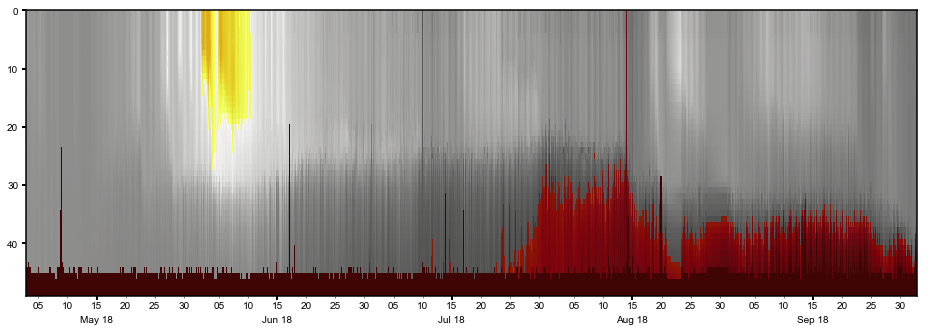

In [19]:
extent = (time_grid.min(),
          time_grid.max(), 
          press_grid.max(), 
          press_grid.min()) # extent of the plots

fig = plt.figure(figsize=(22,5.25))
ax = plt.subplot(1,1,1)
cs = plt.imshow(mesh_grid_OxySat.T,extent=extent, vmin=75, vmax=125, cmap=cmocean.cm.oxy)
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=[5,10,15,20,25,30]))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax.xaxis.set_tick_params(which='major', pad=15)


In [20]:
# Calvin Cleaned the park and hold data I sent from ERDDAP... use to create

import pandas as pd

df_ph = pd.read_excel('/Users/bell/Downloads/Stop_Hold_O2sat_V2.xlsx', parse_dates=True, index_col=' Time')

In [21]:
df_phsg = df_ph.groupby('Calibration Cast')

In [22]:
caldata_filled = {}
fillgaps=True
for profileid in list(df_phsg.groups.keys()):
    ###
    # full profile
    #initialize profile parameters
    profiledata = {
                  ' Temperature': [],
                  ' Oxy_Sat': []}
    #fill variables for each profile, taking the median if multiple values within same depth bin
    # and making NaN if no values
    for pg in press_grid:
        """ Take the median value if multiple samples occur within same depth bin"""
        for parameter in profiledata.keys():
            if not parameter in ['Statistics']:
                ireg_ind = np.where((df_phsg.get_group(profileid)[' Depth'] > pg) & (df_phsg.get_group(profileid)[' Depth'] <= pg+interval))
                profiledata[parameter] = np.hstack((profiledata[parameter], df_phsg.get_group(profileid)[parameter][ireg_ind[0]].median()))
            else:
                profiledata['Statistics'] = np.hstack((profiledata['Statistics'], ireg_ind[0].size))

    for parameter in profiledata.keys():
        if fillgaps:
            mask = np.isnan(profiledata[parameter])
            profiledata[parameter][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), profiledata[parameter][~mask], right=-100000)

    profiledata['datetime'] = df_phsg.get_group(profileid).index[0].to_pydatetime()
    ###
    caldata_filled.update({profileid: profiledata})

In [23]:
parameter=' Oxy_Sat'
np2d=[]
np2d = [np2d + list(v[parameter]) for k,v in caldata_filled.items()]

time_grid = time_interp(caldata_filled[list(caldata_filled.keys())[0]]['datetime'],
                        caldata_filled[list(caldata_filled.keys())[-1]]['datetime'])

date_time = [date2num(v['datetime'],'Days since 0001-1-1') for k,v in caldata_filled.items()]

mesh_grid_func = interpolate.interp2d(press_grid,date_time,np.array(np2d),kind='linear',bounds_error=False,fill_value=-100000)
mesh_grid_OxyConc_ph = mesh_grid_func(press_grid,time_grid)

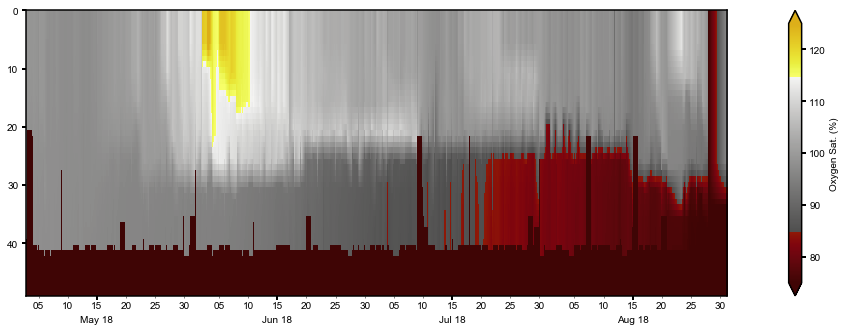

In [31]:
extent = (time_grid.min(),
          time_grid.max(), 
          press_grid.max(), 
          press_grid.min()) # extent of the plots

fig = plt.figure(figsize=(22,5.25))
ax = plt.subplot(1,1,1)
cs = plt.imshow(mesh_grid_OxyConc_ph.T,extent=extent, vmin=75, vmax=125, cmap=cmocean.cm.oxy,label='oxy')

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Oxygen Sat. (%)')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=[5,10,15,20,25,30]))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax.xaxis.set_tick_params(which='major', pad=15)


In [59]:
np.shape(mesh_grid_OxyConc_ph)

(2891, 50)

In [44]:
np.shape(mesh_grid_OxySat[:2891,:])

(2891, 50)

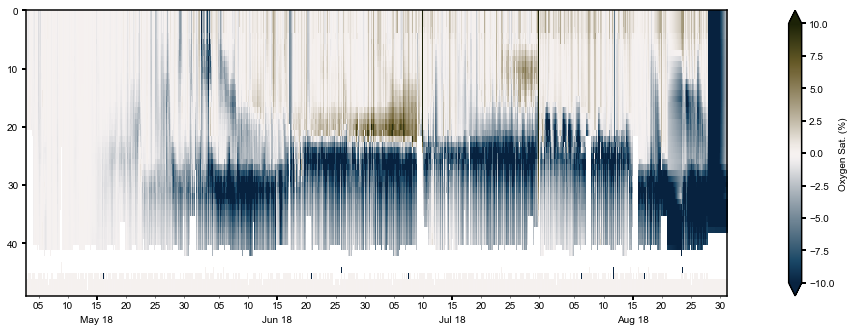

In [58]:
oxydiff = mesh_grid_OxyConc_ph-mesh_grid_OxySat[:2891,:]
oxydiff[np.abs(oxydiff)>1000] = np.nan

extent = (time_grid.min(),
          time_grid.max(), 
          press_grid.max(), 
          press_grid.min()) # extent of the plots

fig = plt.figure(figsize=(22,5.25))
ax = plt.subplot(1,1,1)
cs = plt.imshow((oxydiff).T,extent=extent, vmin=-10,vmax=10,cmap=cmocean.cm.diff,label='oxy')

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Oxygen Sat. (%)')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=[5,10,15,20,25,30]))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax.xaxis.set_tick_params(which='major', pad=15)


In [51]:
oxydiff

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.86522605e-01, -1.86522605e-01, -1.86522605e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.72154466e-01, -2.72154466e-01, -2.72154466e-01, ...,
        -1.45519152e-11, -1.45519152e-11, -1.45519152e-11],
       ...,
       [-9.33423449e-01, -9.33423449e-01, -9.33423449e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.46160040e-01, -6.46160040e-01, -6.46160040e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.90409283e-01,  4.90409283e-01,  4.90409283e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])